In [1]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

Using TensorFlow backend.


0


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt

from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Bidirectional, SpatialDropout1D
from keras.layers import BatchNormalization, Flatten
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Layer

from keras.initializers import *
from keras.optimizers import Nadam
import keras.backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
import tensorflow as tf
import os
import time
import gc
import re


In [3]:
train_df = pd.read_csv("./input/train.csv")

print("Train shape : ",train_df.shape)
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=2019)


Train shape :  (1306122, 3)


In [4]:

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):

    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))





In [5]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use #99.99%

## fill up the missing values
X = train_df["question_text"].fillna("_na_").values
X_test = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='') # lower=False)
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
X = pad_sequences(X, maxlen=maxlen,truncating='post')
X_test = pad_sequences(X_test, maxlen=maxlen, truncating='post')

## Get the target values
Y = train_df['target'].values
Y_test = test_df['target'].values



In [6]:
del train_df, test_df
gc.collect()

27

In [7]:
word_index = tokenizer.word_index
max_features = len(word_index)+1
def load_glove(word_index):
    EMBEDDING_FILE = './input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
 
def load_para(word_index):
    EMBEDDING_FILE = './input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100 and o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [8]:
emb_matrix_1 = load_glove(word_index)
emb_matrix_2 = load_para(word_index)
embedding_matrix = np.add(0.7*emb_matrix_1, 0.3*emb_matrix_2)
del emb_matrix_1, emb_matrix_2
gc.collect()
np.shape(embedding_matrix)

/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(185582, 300)

In [9]:
#def squash(vectors, axis=-1):
  
    #_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    #cale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    #eturn scale * vectors
    #s_squared_norm = K.sum(K.square(vectors, keepdims=True)
    #scale = K.sqrt(s_squared_norm + K.epsilon())
    #return vectors/scale
                           
def squash(x, axis=-1):
 
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale                           

# A Capsule Implementation from Keras example
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                     self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                     input_dim_capsule,
                                     self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
      
        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(tf.keras.backend.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [10]:
def model_final():
    K.clear_session()       
    inp = Input(shape=(maxlen,))
    emb_out = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    sd_out = SpatialDropout1D(rate=0.2)(emb_out)
    lstm_out = Bidirectional(CuDNNLSTM(100, return_sequences=True, 
                             kernel_initializer=glorot_normal(seed=12342), 
                             recurrent_initializer=orthogonal(gain=1.0, seed=12343)))(sd_out)

    cap_out = Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(lstm_out)
    fl_out = Flatten()(cap_out)

    d_out = Dense(100, activation="relu", kernel_initializer=glorot_normal(seed=12346))(fl_out)
    drop_out = Dropout(0.12)(d_out)
    bn_out = BatchNormalization()(drop_out)
   
    final_out = Dense(1, activation="sigmoid")(bn_out)
   
    model = Model(inputs=inp, outputs=final_out)
    model.compile(loss='binary_crossentropy', optimizer=Nadam(),metrics=['accuracy'])
    #model.summary()
    return model

In [11]:
def f1_opt_thresh(y_true, y_pred):
   
    f1_max = 0
    opt_thresh = 0

    for thresh in np.arange(0.2, 0.601, 0.01):
        thresh = np.round(thresh, 2)
 
        f1_score = metrics.f1_score(y_true, (y_pred>thresh).astype(int))
        if(f1_score > f1_max):
            f1_max = f1_score
            opt_thresh = thresh
    
    return(f1_max, opt_thresh)

In [12]:


class History(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_acc = []
        self.val_acc = []
        self.val_loss = []
        for keys in logs:
           print(keys) 

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
    #Store val_acc/loss per batch    
    def on_epoch_end(self, batch, logs={}):    
        self.val_acc.append(logs.get('val_acc'))
        self.val_loss.append(logs.get('val_loss'))
        
# Compute class_weights for imbalanced train set
def compute_class_weight(input_list):

  class_weights = class_weight.compute_class_weight('balanced', 
                                                   np.unique(input_list),  
                                                   input_list)
                                                   
  return(class_weights)                                                   
        
#define callback functions
history = History()


#class_weights = compute_class_weight(train_y)


In [13]:

class_weights = [0.53290517, 80.97591407]
kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
kfold_threshold = []
filepath="./output/weights_kfold.h5"
y_test = np.zeros((X_test.shape[0], ))
val_loss_array = []
val_acc_array = []
train_acc_array = []
train_loss_array = []
for i, (train_index, valid_index) in enumerate(kfold.split(X, Y)):
    X_train, X_val, Y_train, Y_val = X[train_index], X[valid_index], Y[train_index], Y[valid_index]
  
    chk_point = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.0001, verbose=2)
    callbacks = [chk_point, reduce_lr, history]
    model = model_final()
    if i == 0:
        print(model.summary()) 
    model.fit(X_train, Y_train, batch_size=512, epochs=6, validation_data=(X_val, Y_val), verbose=2, 
              class_weight=class_weights, callbacks=callbacks, 
             )
    val_loss_array.append(history.val_loss)
    val_acc_array.append(history.val_acc)
    train_loss_array.append(history.train_loss)
    train_acc_array.append(history.train_acc)
    
    model.load_weights(filepath)
    y_pred = model.predict([X_val], batch_size=1024, verbose=2)
    y_test += np.squeeze(model.predict([X_test], batch_size=1024, verbose=2))/5
    
    #select the threshold that maximizes y_pred
    f1, threshold = f1_opt_thresh(np.squeeze(Y_val), np.squeeze(y_pred))
    print('Optimal F1: {:.4f} at threshold: {:.4f}'.format(f1, threshold))
    kfold_threshold.append(threshold)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 70, 300)           55674600  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 200)           321600    
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 10)            20000     
_________________________________________________________________
flatten_1 (Flatten)  

 - 79s - loss: 0.0908 - acc: 0.9633 - val_loss: 0.0964 - val_acc: 0.9610

Epoch 00004: val_loss improved from 0.09948 to 0.09643, saving model to ./output/weights_kfold.h5
Epoch 5/6
 - 79s - loss: 0.0865 - acc: 0.9649 - val_loss: 0.0979 - val_acc: 0.9606

Epoch 00005: val_loss did not improve from 0.09643

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000720000034198165.
Epoch 6/6
 - 81s - loss: 0.0810 - acc: 0.9670 - val_loss: 0.0995 - val_acc: 0.9610

Epoch 00006: val_loss did not improve from 0.09643

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004320000065490603.
Optimal F1: 0.6858 at threshold: 0.3600


In [14]:
y_test = y_test.reshape((-1, 1))
avg_threshold = np.mean(kfold_threshold)
pred_test_y = (y_test>avg_threshold).astype(int)
f1_score = metrics.f1_score(Y_test, pred_test_y)
print(f1_score)

0.7004976275893993


In [15]:
#del model, embedding_matrix, X_test, X_train, y_test, Y_test
len(train_loss_array)

5

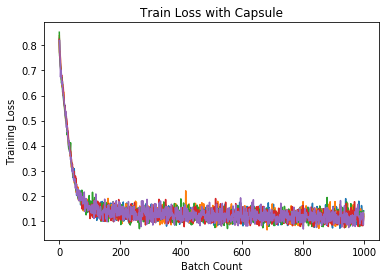

In [16]:
import matplotlib.pyplot as plt
x = range(len(history.train_loss))
%matplotlib inline
fig = plt.figure()
plt.title('Train Loss with Capsule')
plt.xlabel('Batch Count')
plt.ylabel('Training Loss')
plt.plot(x[0:1000], train_loss_array[0][0:1000], x[0:1000], train_loss_array[1][0:1000],x[0:1000], train_loss_array[2][0:1000], x[0:1000], train_loss_array[3][0:1000], x[0:1000], train_loss_array[4][0:1000])
#plt.plot(x, history.val_acc)
plt.show()
fig.savefig('capsule_train_loss')

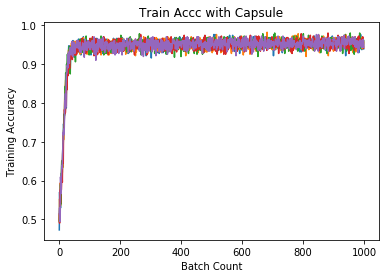

In [17]:
import matplotlib.pyplot as plt
x = range(len(history.train_acc))
%matplotlib inline
fig = plt.figure()
plt.title('Train Accc with Capsule')
plt.xlabel('Batch Count')
plt.ylabel('Training Accuracy')
plt.plot(x[0:1000], train_acc_array[0][0:1000], x[0:1000], train_acc_array[1][0:1000],x[0:1000], train_acc_array[2][0:1000], x[0:1000], train_acc_array[3][0:1000], x[0:1000], train_acc_array[4][0:1000])
#plt.plot(x, history.val_acc)
plt.show()
fig.savefig('capsule_train_acc')

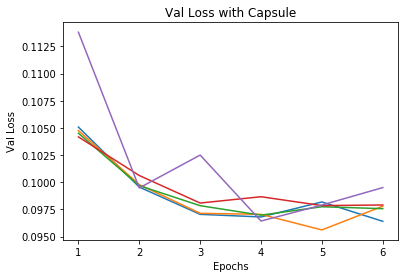

In [23]:
import matplotlib.pyplot as plt
x = [1, 2, 3, 4, 5, 6]
%matplotlib inline
fig = plt.figure()
plt.title('Val Loss with Capsule')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.plot(x, val_loss_array[0], x, val_loss_array[1],x, val_loss_array[2], x, val_loss_array[3], x, val_loss_array[4])
plt.xticks(np.arange(min(x), max(x)+1, 1))
#plt.plot(x, history.val_acc)
plt.show()
fig.savefig('capsule_val_loss')

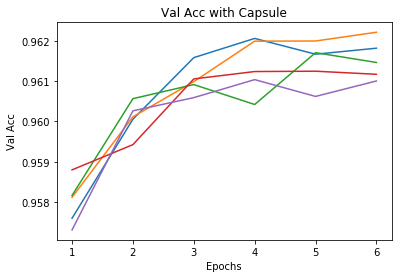

In [24]:
import matplotlib.pyplot as plt
x = [1, 2, 3, 4, 5, 6]
%matplotlib inline
fig = plt.figure()
plt.title('Val Acc with Capsule')
plt.xlabel('Epochs')
plt.ylabel('Val Acc')
plt.plot(x, val_acc_array[0], x, val_acc_array[1],x, val_acc_array[2], x, val_acc_array[3], x, val_acc_array[4])
plt.xticks(np.arange(min(x), max(x)+1, 1))
#plt.plot(x, history.val_acc)
plt.show()
fig.savefig('capsule_val_acc')

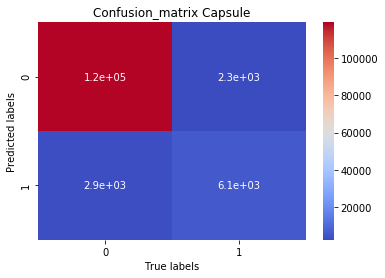

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
import seaborn as sns
def get_confusion_matrix(test_y, pred,title):
    cm=confusion_matrix(pred,test_y)
   
    fig = plt.figure()
    sns.heatmap(cm, cmap='coolwarm', annot=True)
    plt.title(title)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()
    fig.savefig('capsule_confusion_matrix')
 
get_confusion_matrix(Y_test,pred_test_y,'Confusion_matrix Capsule')    

In [22]:
from sklearn.metrics import recall_score, precision_score
r = recall_score(Y_test, pred_test_y, average='binary')
p = precision_score(Y_test, pred_test_y, average='binary')
print('Precision: {:.3f} Recall: {:.3f}'.format(p, r))


Precision: 0.675 Recall: 0.728


In [ ]:
#del model, embedding_matrix, X_test, X_train, y_test, Y_test